In [24]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from xgboost import XGBRegressor as XGBR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
import math
import shap
import joblib
import mlxtend
from mlxtend.feature_selection import ExhaustiveFeatureSelector
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [25]:
mdf = pd.read_pickle("df_coeff.pkl")
mdf = mdf.reset_index()
mdf=mdf.drop('index', axis=1)

In [26]:
Results_df = pd.read_pickle("Results_df.pkl")

,GasRH,H2S,FlowR,C,H/C,pH,SBet,PTemp,BRH,PSize,...,T,T_xgbr,T_gbr,T_rfr,K_pred,K_pred_teor,b_xgbr,b_gbr,b_rfr,a_pred
0,0.0,50.0,40.0,22.20,0.355856,5.25,2.10,100.0,0.0,0.825,...,25.183979,26.285999,29.279,55.128,8.821000,3.906200,32.176998,35.073,58.237,4.592
1,0.0,50.0,40.0,22.20,0.355856,5.40,6.40,200.0,0.0,0.825,...,123.303715,116.674004,120.113,102.863,26.811001,20.706128,125.272003,125.883,112.033,7.381
2,0.0,50.0,40.0,22.20,0.355856,6.00,11.30,300.0,0.0,0.825,...,140.847082,135.927994,140.203,123.105,21.170000,23.809988,144.746002,147.944,132.437,8.800
3,0.0,50.0,40.0,22.20,0.355856,9.50,20.35,400.0,0.0,0.825,...,494.556257,479.218994,484.514,434.773,42.563000,89.022629,501.013000,503.046,461.235,16.549
4,0.0,50.0,40.0,22.20,0.355856,9.00,22.60,500.0,0.0,0.825,...,249.228841,288.127014,287.227,310.366,30.948999,43.351302,309.875000,311.657,321.664,10.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,40.0,10000.0,2700.0,38.94,0.170262,8.08,45.00,700.0,0.0,1.000,...,0.131768,5.862000,7.001,22.685,1.598000,0.015717,9.454000,16.030,29.904,2.405
126,40.0,10000.0,2700.0,27.71,0.174666,12.27,12.00,700.0,0.0,1.000,...,45.104694,45.359001,48.630,78.575,17.523001,7.202890,54.292000,56.818,80.714,3.918
127,40.0,10000.0,2700.0,33.73,0.143492,9.73,55.00,700.0,90.0,1.000,...,12.811105,14.558000,16.805,38.324,13.001000,1.921055,19.400999,24.227,46.313,2.897
128,40.0,10000.0,2700.0,38.94,0.170262,8.08,45.00,700.0,90.0,1.000,...,45.242404,42.431999,44.945,42.460,18.171000,7.225982,48.912998,51.569,48.800,3.923


In [ ]:
ddis=Results_df[['a', 'b' , 'k', 'T']]

In [28]:
fontdict1={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'arial'}
fontdict2={'fontsize': 12, 'fontweight': 'bold', 'fontstyle': 'oblique', 'color': 'b', 'fontfamily': 'arial'}

In [29]:
mdf= mdf[['GasTemp', 'GasRH', 'H2SConcentration', 'flowRate', 'H/C', 'pH','C', 'N/C', 'O',
            'S_Bet','PyrolisTemp', 'BiocharRH', 'particleSize','S_Weight', 'Col_d', 'Col_h', 'a', 'b', 'K', 'T']]
Features= mdf[['GasRH', 'H2SConcentration', 'flowRate','C', 'H/C', 'pH',
            'S_Bet','PyrolisTemp', 'BiocharRH', 'particleSize','S_Weight', 'Col_h']]
Target= mdf[['a', 'b', 'K', 'T']]
df=mdf[['GasRH', 'H2SConcentration', 'flowRate','C', 'H/C', 'pH',
            'S_Bet','PyrolisTemp', 'BiocharRH', 'particleSize','S_Weight', 'Col_h', 'a', 'b', 'K', 'T']]
df = df.rename(columns={'H2SConcentration': 'H2S'})
df = df.rename(columns={'PyrolisTemp': 'PTemp'})
df = df.rename(columns={'particleSize': 'PSize'})
df = df.rename(columns={'flowRate': 'FlowR'})
df = df.rename(columns={'BiocharRH': 'BRH'})
df = df.rename(columns={'S_Bet': 'SBet'})
df = df.rename(columns={'S_Weight': 'SW'})
df = df.rename(columns={'Col_h': 'ColH'})
#df=(df-df.min())/(df.max()-df.min())

# Determining b

In [30]:

X= df[['GasRH', 'H2S', 'FlowR', 'C', 'H/C', 'pH', 'SBet', 'PTemp', 'BRH', 'PSize', 'SW', 'ColH']]
y=df['b']
#-------------------------------------------------------------------------------------------------------------

for rs in [71]:                   # ,201,248,3,13,43,48,71
    print('Random State: ', rs)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = rs) # Split the data
    X_train.to_csv('X_train_XGBR.csv', index=False)
    X_test.to_csv('X_test_XGBR.csv', index=False)
    y_train.to_csv('y_train_XGBR.csv', index=False)
    y_test.to_csv('y_test_XGBR.csv', index=False)

# Train the model on the training set

    est=XGBR(learning_rate =0.013, n_estimators=300, reg_alpha=0.1, reg_lambda=0.04, max_depth =6, random_state =8)   
    est.fit(X_train, y_train)

# Make predictions on the testing set
    y_pred_test = est.predict(X_test).round(2)
    y_pred_train = est.predict(X_train).round(2)
          
    r2_a_train = r2_score(y_train, y_pred_train)
    r2_a_test = r2_score(y_test,   y_pred_test)
    CV5_scores = cross_val_score(est, X_train, y_train, cv=5)

    print('train: R2 score for predicting b coeff = ', r2_a_train.round(3))
    print('test: R2 score for predicting b coeff = ', r2_a_test.round(3))
    print('cv5: R2 score for predicting b coeff = ', CV5_scores.mean().round(3))
    print('---')
    
    #---------------------------------------------------------------------------------------------------------------
joblib.dump(est, 'XGBR_dr.sav')

Random State:  71
train: R2 score for predicting b coeff =  0.999
test: R2 score for predicting b coeff =  0.947
cv5: R2 score for predicting b coeff =  0.902
---


['XGBR_dr.sav']

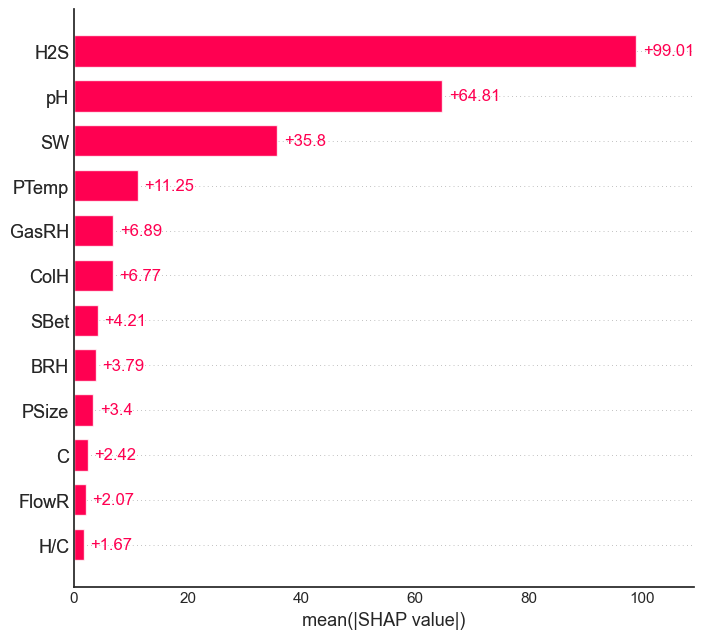

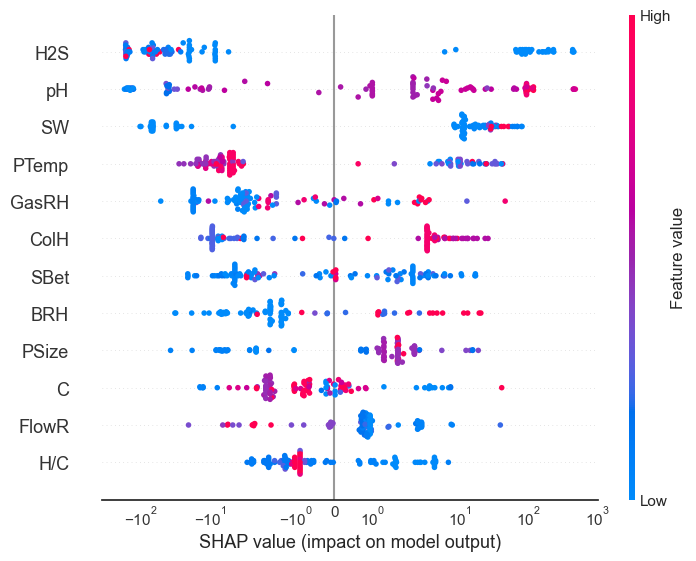

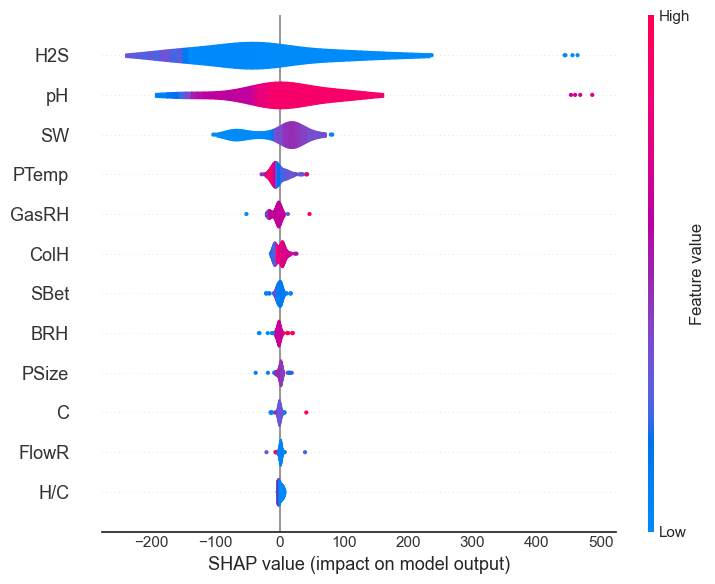

In [31]:
estimator = est
explainer = shap.Explainer(estimator, seed = 30, algorithm ='tree')
shap_values = explainer(X_train) 
ax=shap.plots.bar(shap_values, max_display=12, order=shap.Explanation.abs, show=True)
ax1=shap.plots.beeswarm(shap_values, max_display=12, log_scale=True)
ax2=shap.summary_plot(shap_values, X_train, plot_type="violin", color_bar_label='Feature value',layered_violin_max_num_bins=40)



In [32]:
X= df[['GasRH', 'H2S', 'FlowR', 'C', 'H/C', 'pH', 'SBet', 'PTemp', 'BRH', 'PSize', 'SW', 'ColH']]
y=df['b']
#-------------------------------------------------------------------------------------------------------------

for rs in [71]:                   # 41,71
    print('Random State: ', rs)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = rs) # Split the data

# Train the model on the training set
    est=GBR(learning_rate=0.018, n_estimators=200, alpha=0.1, random_state=8, max_depth=6 )    
    est.fit(X_train, y_train)

# Make predictions on the testing set
    y_pred_test = est.predict(X_test).round(2)
    y_pred_train = est.predict(X_train).round(2)
          
    r2_a_train = r2_score(y_train, y_pred_train)
    r2_a_test = r2_score(y_test,   y_pred_test)
    CV5_scores = cross_val_score(est, X_train, y_train, cv=5)

    print('train: R2 score for predicting b coeff = ', r2_a_train.round(3))
    print('test: R2 score for predicting b coeff = ', r2_a_test.round(3))
    print('cv5: R2 score for predicting b coeff = ', CV5_scores.mean().round(3))
    print('---')
    
    #---------------------------------------------------------------------------------------------------------------
joblib.dump(est, 'GBR_dr.sav')

Random State:  71
train: R2 score for predicting b coeff =  0.999
test: R2 score for predicting b coeff =  0.944
cv5: R2 score for predicting b coeff =  0.886
---


['GBR_dr.sav']

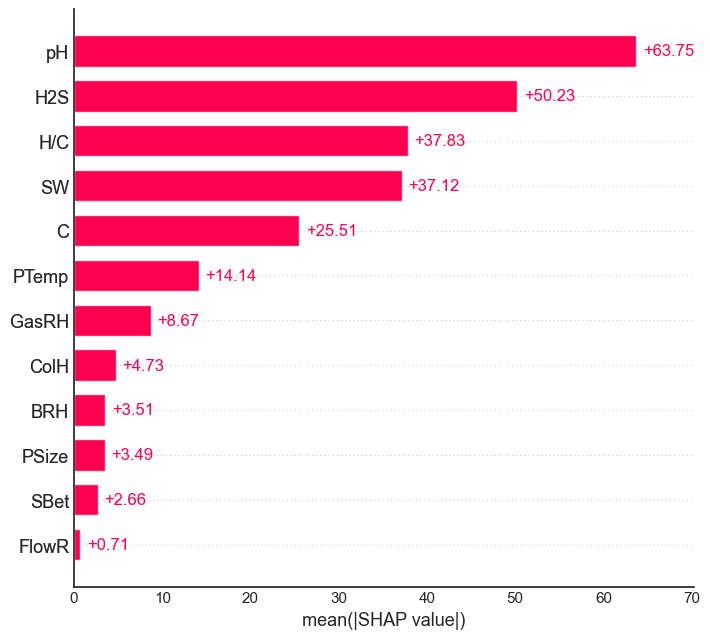

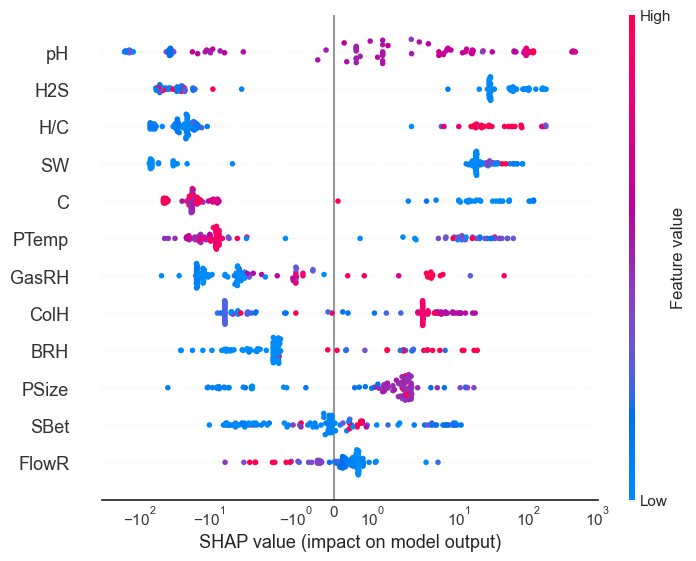

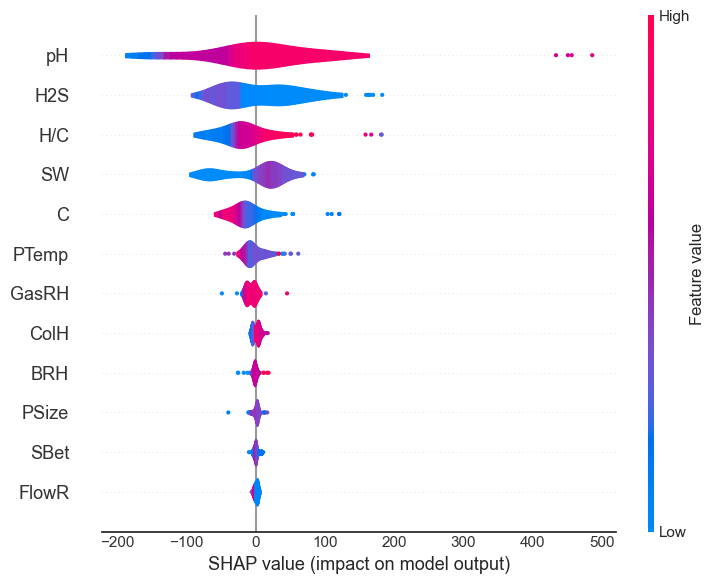

In [33]:
estimator = est
explainer = shap.Explainer(estimator, seed = 30, algorithm ='tree')
shap_values = explainer(X_train) 
ax=shap.plots.bar(shap_values, max_display=12, order=shap.Explanation.abs, show=True)
ax1=shap.plots.beeswarm(shap_values, max_display=12, log_scale=True)
ax2=shap.summary_plot(shap_values, X_train, plot_type="violin", color_bar_label='Feature value',layered_violin_max_num_bins=40)


In [34]:

X= df[['GasRH', 'H2S', 'FlowR', 'C', 'H/C', 'pH', 'SBet', 'PTemp', 'BRH', 'PSize', 'SW', 'ColH']]
y=df['b']
#-------------------------------------------------------------------------------------------------------------

for rs in [71]:                   # ,201,248,3,13,43,48,71
    print('Random State: ', rs)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = rs) # Split the data

# Train the model on the training set
#    est=GBR(learning_rate=0.0235, n_estimators=260, alpha=0.1, random_state=10, max_depth=5 )
#    est=XGBR(learning_rate =0.012, n_estimators=340, reg_alpha=0.071, reg_lambda=0.04, max_depth =6, random_state =5)
    est=RF(n_estimators=500, max_depth=7, min_samples_leaf=1,criterion='squared_error', random_state=3 )
#    est = KNN(n_neighbors=3, leaf_size=20)
#    est=MLPRegressor(hidden_layer_sizes=(600, 80), activation='relu', solver='adam', max_iter=10000, random_state=0)
    
    est.fit(X_train, y_train)

# Make predictions on the testing set
    y_pred_test = est.predict(X_test).round(2)
    y_pred_train = est.predict(X_train).round(2)
          
    r2_a_train = r2_score(y_train, y_pred_train)
    r2_a_test = r2_score(y_test,   y_pred_test)
    CV5_scores = cross_val_score(est, X_train, y_train, cv=5)

    print('train: R2 score for predicting b coeff = ', r2_a_train.round(3))
    print('test: R2 score for predicting b coeff = ', r2_a_test.round(3))
    print('cv5: R2 score for predicting b coeff = ', CV5_scores.mean().round(3))
    print('---')
    
    #---------------------------------------------------------------------------------------------------------------
joblib.dump(est, 'RFR_dr.sav')

Random State:  71
train: R2 score for predicting b coeff =  0.981
test: R2 score for predicting b coeff =  0.842
cv5: R2 score for predicting b coeff =  0.836
---


['RFR_dr.sav']

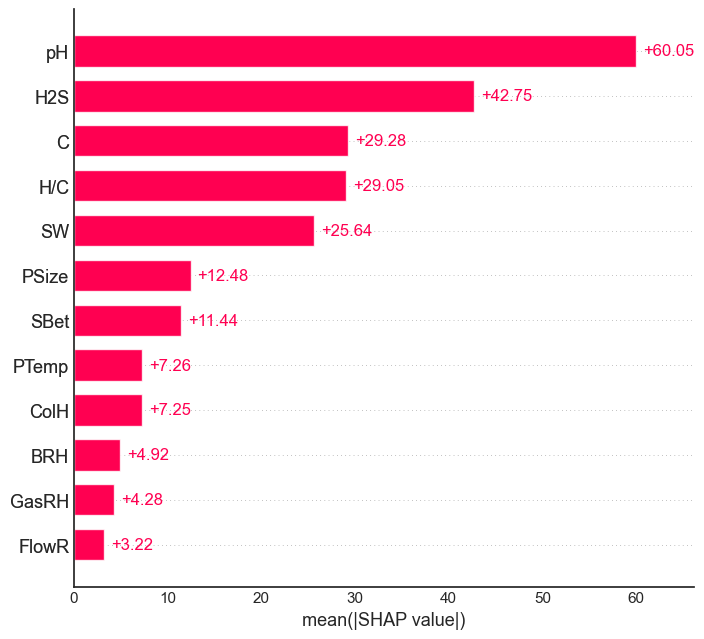

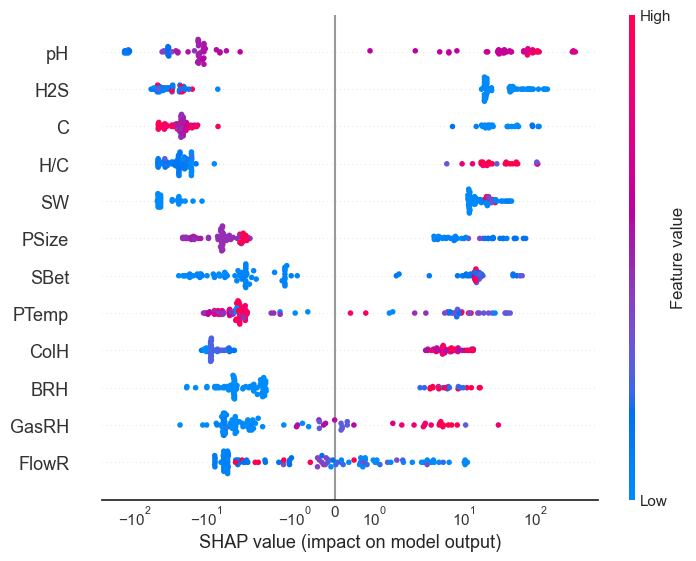

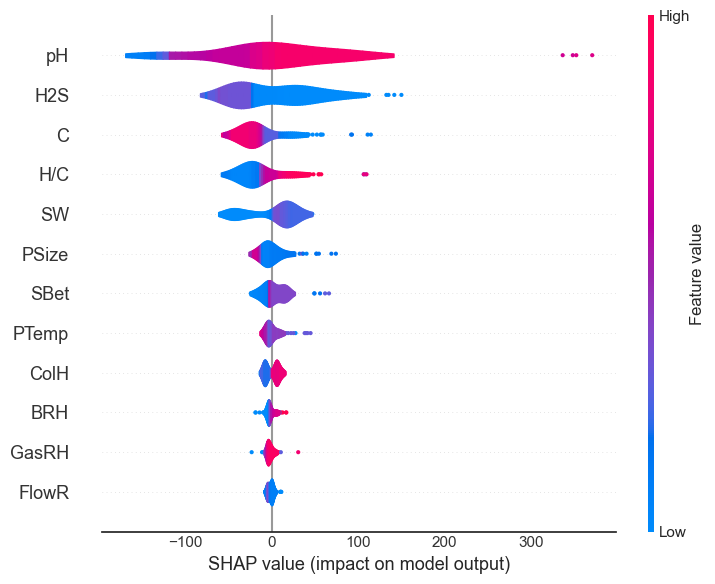

In [35]:
estimator = est
explainer = shap.Explainer(estimator, seed = 30, algorithm ='tree')
shap_values = explainer(X_train) 
ax=shap.plots.bar(shap_values, max_display=12, order=shap.Explanation.abs, show=True)
ax1=shap.plots.beeswarm(shap_values, max_display=12, log_scale=True)
ax2=shap.summary_plot(shap_values, X_train, plot_type="violin", color_bar_label='Feature value',layered_violin_max_num_bins=40)


In [37]:
XGBR_M=joblib.load('XGBR_dr.sav')
GBR_M= joblib.load('GBR_dr.sav')
RFR_M= joblib.load('RFR_dr.sav')

# ploting accuracy

In [38]:
plt.style.use('seaborn-white')
# Set the default text font size
plt.rc('font', size=22)
# Set the fig title font size
plt.rc('axes', titlesize=22)
# Set the axes labels font size
plt.rc('axes', labelsize=2)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=20)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=20)
# Set the legend font size
plt.rc('legend', fontsize=22)
# Set the font size of the figure title
plt.rc('figure', titlesize=22)

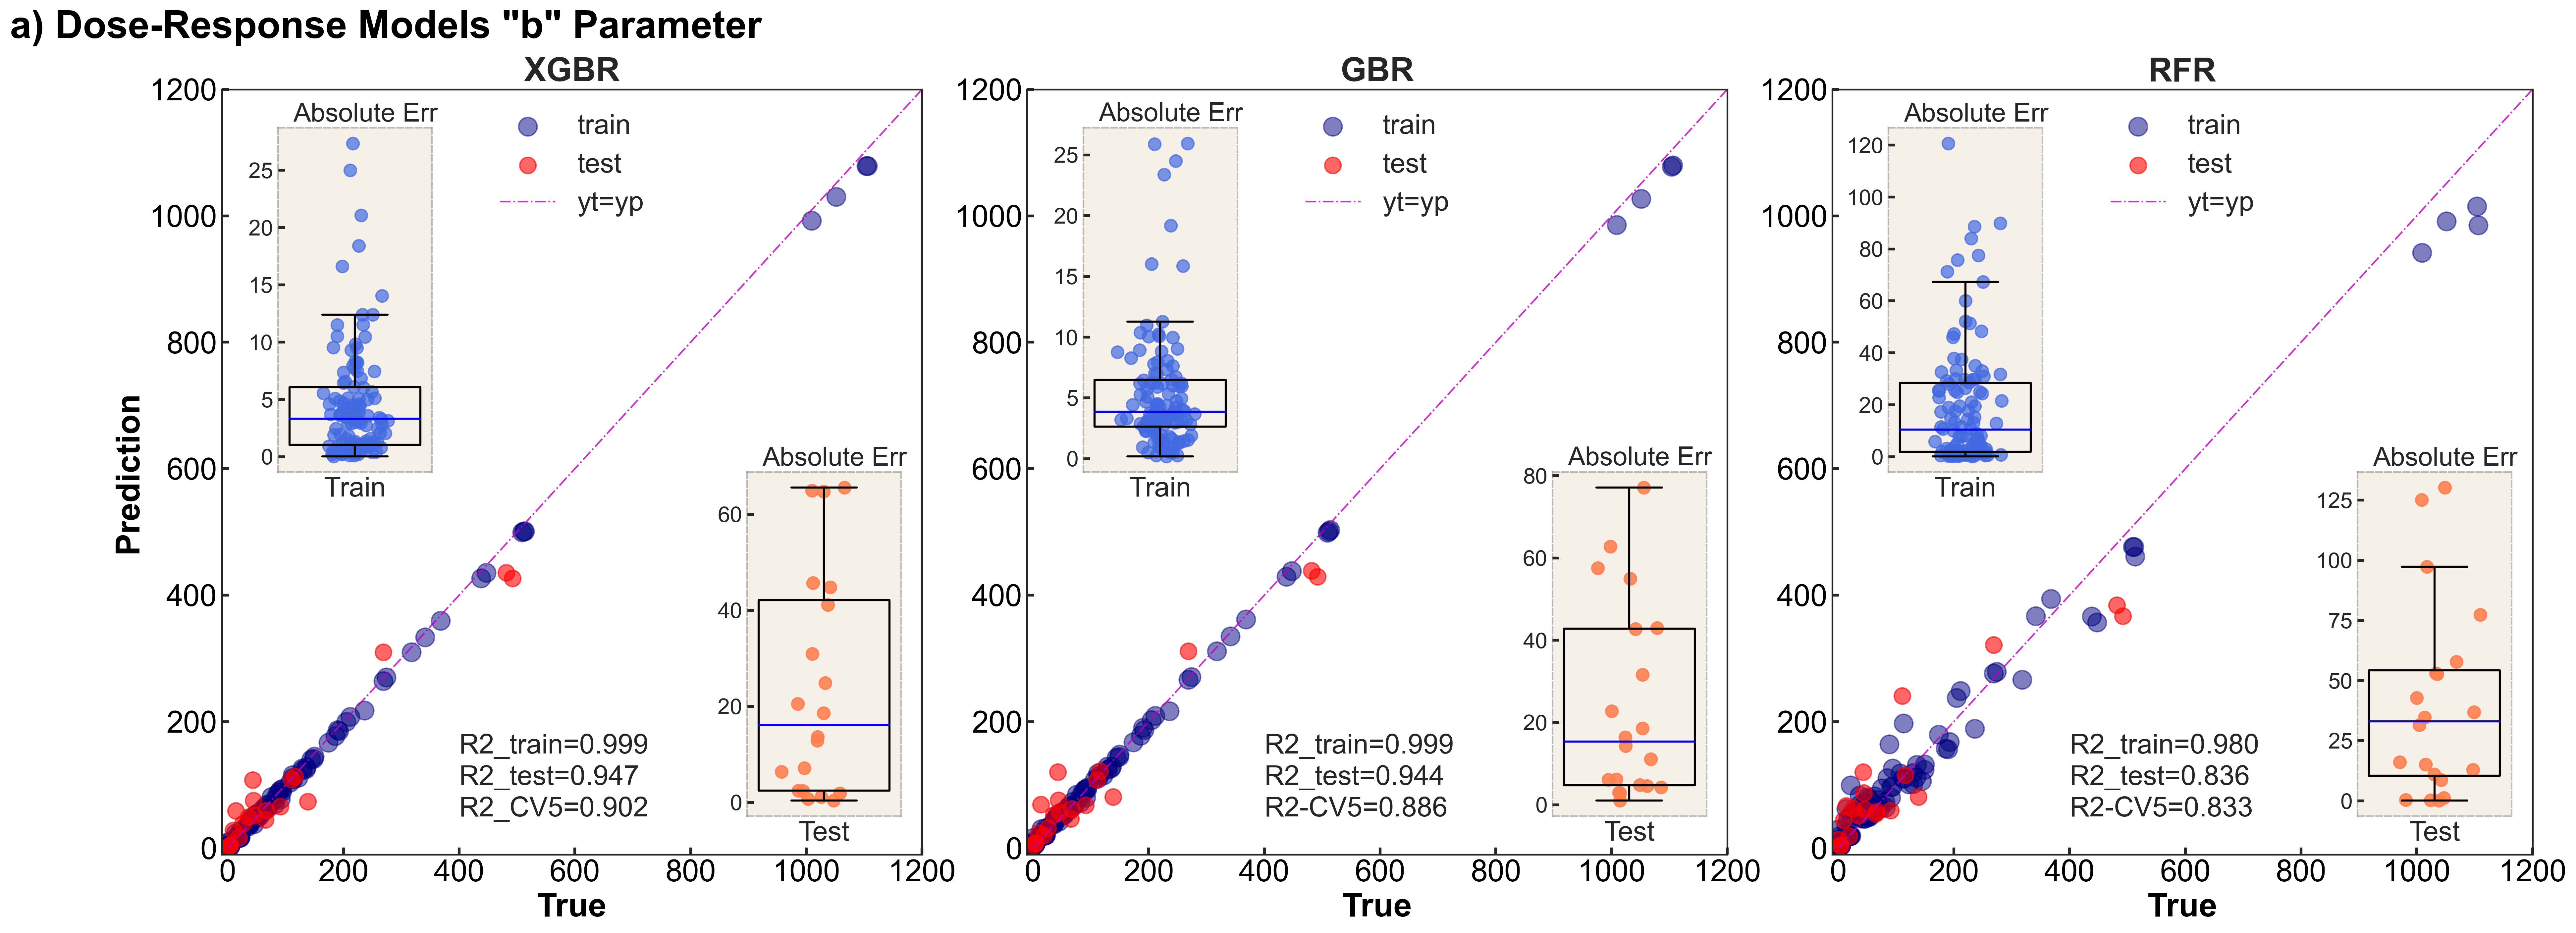

In [39]:
import matplotlib.gridspec as gridspec
 
fontdict1={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'arial'}
fontdict2={'fontsize': 24, 'fontweight': 'bold', 'color': 'k', 'fontfamily': 'arial'}
rs=[71,71,71]
XGBR=joblib.load('XGBR_dr.sav')
GBR= joblib.load('GBR_dr.sav')
RFR= joblib.load('RFR_dr.sav')

yp_train_XGBR= XGBR.predict(X_train)
yp_train_GBR= GBR.predict(X_train)
yp_train_RFR= RFR.predict(X_train)

yp_test_XGBR= XGBR.predict(X_train)
yp_test_GBR= GBR.predict(X_train)
yp_test_RFR= RFR.predict(X_train)

fig = plt.figure(figsize=(30,10), dpi=300)
gs  = gridspec.GridSpec(1, 3, wspace=0.15, hspace=0.1, width_ratios=[1, 1, 1], height_ratios=[1])
modelsName=['XGBR', 'GBR', 'RFR']

YP_train=[yp_train_XGBR,yp_train_GBR,yp_train_RFR]

j=0
for i in range(0,3):
    ax = fig.add_subplot(gs[0,j])
    #------------------------------------------------ Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = rs[i])
    yp_train_XGBR= XGBR.predict(X_train)
    yp_train_GBR= GBR.predict(X_train)
    yp_train_RFR= RFR.predict(X_train)

    yp_test_XGBR= XGBR.predict(X_test)
    yp_test_GBR= GBR.predict(X_test)
    yp_test_RFR= RFR.predict(X_test)
    YP_train=[yp_train_XGBR, yp_train_GBR, yp_train_RFR]
    YP_test=[yp_test_XGBR, yp_test_GBR, yp_test_RFR]
    
    ax.scatter(y_train, YP_train[i], s=180, color='navy',label='train', alpha=0.5)
    ax.scatter(y_test, YP_test[i], s=140, color='r',label='test', alpha=0.6)
    ax.plot([0, 1200], [0, 1200], 'k-.', lw=1.2, label='yt=yp', alpha=.8, color='m')

    #-----------------------------------------------------------------------------------
    ax2=ax.inset_axes([0.08, .50, 0.22, 0.45])
    ax2.set_xticks([])
    ax2.tick_params(axis='y', labelsize=16)
    ax2.spines[['top', 'bottom','right', 'left' ]].set_color('gray')
    ax2.spines[['top', 'bottom','right', 'left' ]].set_linestyle('--')
    ax2.spines[['top', 'bottom','right', 'left' ]].set_alpha(0.5)
    ax2.set_facecolor('tan')
    ax2.patch.set_alpha(0.2)
    #--------------------------------------------
    # calculate the train eroors
    err_train=abs(y_train-YP_train[i]).round(3)
    #--------------------------------------------
    ax2.boxplot(err_train, widths=0.85,labels=['Train'], meanline =True,vert=True,
                showfliers = False,
                medianprops = {"color": "b", "linewidth": 1.5},
                boxprops = {"color": "k", "linewidth": 1.5},
                whiskerprops = {"color": "k", "linewidth": 1.5},
                capprops = {"color": "k", "linewidth": 1.5})
    xs, names = [], []
    vals=np.asanyarray(err_train)
    #names.append(col)
    xs.append(np.random.normal(1, 0.1, len(err_train)))
    ax2.scatter(xs,err_train, alpha= 0.7, marker='o', s=80, color='royalblue')
    ax2.text(0.6, 1.07*max(err_train), 'Absolute Err', fontsize = 19)
    #-----------------------------------------------------------------------------------------
    #-----------------------------------------------------------------------------------------
    ax3=ax.inset_axes([0.75, .05, 0.22, 0.45])
    ax3.tick_params(axis='y', labelsize=16)
    ax3.set_xticks([])
    ax3.spines[['top', 'bottom','right', 'left' ]].set_color('gray')
    ax3.spines[['top', 'bottom','right', 'left' ]].set_linestyle('--')
    ax3.spines[['top', 'bottom','right', 'left' ]].set_alpha(0.5)
    ax3.set_facecolor('tan')
    ax3.patch.set_alpha(0.2)
    #--------------------------------------------
    # calculate the train eroors
    err_test=abs(y_test-YP_test[i]).round(3)
    #--------------------------------------------
    ax3.boxplot(err_test, widths=0.85,labels=['Test'], meanline =True,vert=True,
                showfliers = False,
                medianprops = {"color": "b", "linewidth": 1.5},
                boxprops = {"color": "k", "linewidth": 1.5},
                whiskerprops = {"color": "k", "linewidth": 1.5},
                capprops = {"color": "k", "linewidth": 1.5})
    xs, names = [], []
    vals=np.asanyarray(err_train)
    #names.append(col)
    xs.append(np.random.normal(1, 0.1, len(err_test)))
    ax3.scatter(xs,err_test, alpha= 0.9, marker='o', s=80, color='coral')
    ax3.text(0.6, 1.07*max(err_test), 'Absolute Err', fontsize = 19)
    #------------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------------

    ax.set_xlim([-10, 1200])
    ax.set_ylim([-10, 1200])
    ax.set_xlabel('True', fontdict=fontdict2)
    if j==0:
        ax.set_ylabel('Prediction', fontdict=fontdict2)
    ax.set_title(modelsName[j]  , loc= 'center', fontdict = fontdict1, fontsize=24)
    ax.tick_params(labelcolor='k', labelsize='medium', width=3)
    ax.legend(loc= 'upper center', fontsize=20)
    ax.tick_params(axis='x', which='both', direction='in', length=5, width=2)
    ax.tick_params(axis='y', which='both', direction='in', length=5, width=2)
    ax2.tick_params(axis='y', which='both', direction='in', length=5, width=2)
    ax3.tick_params(axis='y', which='both', direction='in', length=5, width=2)
    #------------------------------------------------------------------------------------------
    R2TR=['R2_train=0.999','R2_train=0.999','R2_train=0.980']
    R2TE=['R2_test=0.947','R2_test=0.944','R2_test=0.836']
    CV5R2=['R2_CV5=0.902','R2-CV5=0.886','R2-CV5=0.833']
    ax.text(400, 150, R2TR[j], fontsize = 20)
    ax.text(400, 100,  R2TE[j], fontsize = 20)
    ax.text(400, 50,  CV5R2[j], fontsize = 20)
    j=j+1
fig.suptitle('a) Dose-Response Models "b" Parameter', fontsize=28, fontweight='bold', color='k', x=.18, y=0.96)
plt.savefig('dr_b_errors', dpi=300)
plt.show()

In [40]:
b_xgbr=XGBR_M.predict(X)
b_gbr=GBR_M.predict(X)
b_rfr=RFR_M.predict(X)

In [41]:
Results_df['b_xgbr']=0
Results_df['b_gbr']=0
Results_df['b_rfr']=0
for i in range(0, len(Results_df)):
    Results_df['b_xgbr'].iloc[i]=float(b_xgbr[i].round(3))
    Results_df['b_gbr'].iloc[i]=float(b_gbr[i].round(3))
    Results_df['b_rfr'].iloc[i]=float(b_rfr[i].round(3))
Results_df.head(5)  

,GasRH,H2S,FlowR,C,H/C,pH,SBet,PTemp,BRH,PSize,...,K,T,T_xgbr,T_gbr,T_rfr,K_pred,K_pred_teor,b_xgbr,b_gbr,b_rfr
0,0.0,50.0,40.0,22.2,0.355856,5.25,2.10,100.0,0.0,0.825,...,10.494361,25.183979,26.285999,29.279,55.128,8.821000,3.906200,32.176998,35.073,58.237
1,0.0,50.0,40.0,22.2,0.355856,5.40,6.40,200.0,0.0,0.825,...,28.650561,123.303715,116.674004,120.113,102.863,26.811001,20.706128,125.272003,125.883,112.033
2,0.0,50.0,40.0,22.2,0.355856,6.00,11.30,300.0,0.0,0.825,...,21.947262,140.847082,135.927994,140.203,123.105,21.170000,23.809988,144.746002,147.944,132.437
3,0.0,50.0,40.0,22.2,0.355856,9.50,20.35,400.0,0.0,0.825,...,42.378810,494.556257,479.218994,484.514,434.773,42.563000,89.022629,501.013000,503.046,461.235
4,0.0,50.0,40.0,22.2,0.355856,9.00,22.60,500.0,0.0,0.825,...,48.022293,249.228841,288.127014,287.227,310.366,30.948999,43.351302,309.875000,311.657,321.664


# Finding a

In [42]:
def dose_response(t, a, b):
    return (1-1/(1+(t/b)**(a)))

def Gompertz(t, K, T):
    return (np.exp(-1*np.exp((1/K)*(T-t))))

In [43]:
from xgboost import XGBRegressor as XGBR
X= df[['GasRH', 'H2S', 'FlowR', 'C', 'H/C', 'pH', 'SBet', 'PTemp', 'BRH', 'PSize', 'SW', 'ColH','b']]
y=df['a']


#-------------------------------------------------------------------------------------------------------------

for rs in [71]:                   # ,201,248,3,13,43,48,71
    print('Random State: ', rs)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = rs) # Split the data

# Train the model on the training set
#    est=GBR(learning_rate=0.0235, n_estimators=260, alpha=0.1, random_state=10, max_depth=5 )
#    est=XGBR(learning_rate =0.012, n_estimators=350, reg_alpha=0.12, reg_lambda=0.06, max_depth =7, random_state =5)
    est=RF(n_estimators=300, max_depth=8, min_samples_leaf=1,criterion='squared_error', random_state=14 )

    
    est.fit(X_train, y_train)

# Make predictions on the testing set
    y_pred_test = est.predict(X_test).round(2)
    y_pred_train = est.predict(X_train).round(2)
    
       
    r2_a_train = r2_score(y_train, y_pred_train)
    r2_a_test = r2_score(y_test,   y_pred_test)
    CV5_scores = cross_val_score(est, X_train, y_train, cv=4)

    print('train: R2 score for predicting a coeff = ', r2_a_train.round(3))
    print('test: R2 score for predicting a coeff = ', r2_a_test.round(3))
    print('cv5: R2 score for predicting a coeff = ', CV5_scores.mean().round(3))
    print('---')
    
    #---------------------------------------------------------------------------------------------------------------
joblib.dump(est, 'RFR_a_dr.sav')

Random State:  71
train: R2 score for predicting a coeff =  0.916
test: R2 score for predicting a coeff =  0.78
cv5: R2 score for predicting a coeff =  0.414
---


['RFR_a_dr.sav']

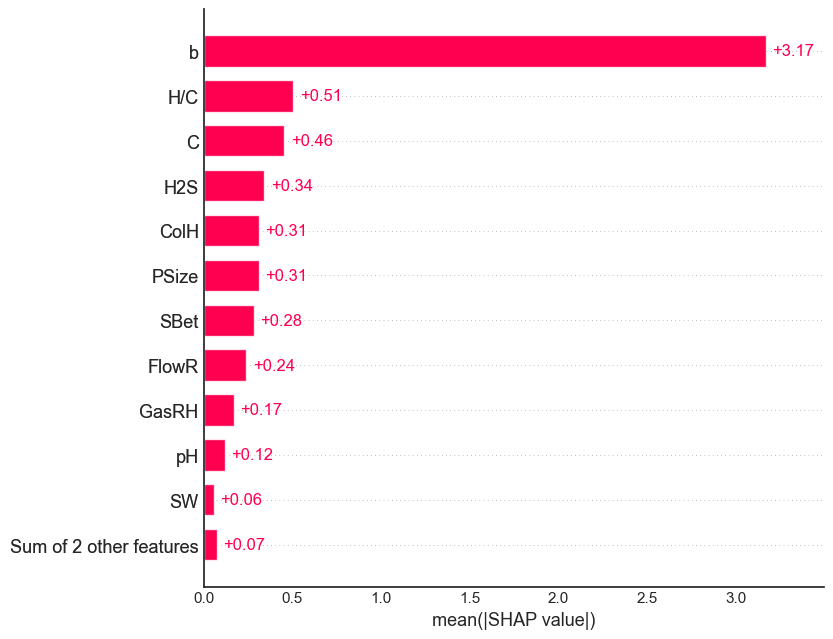

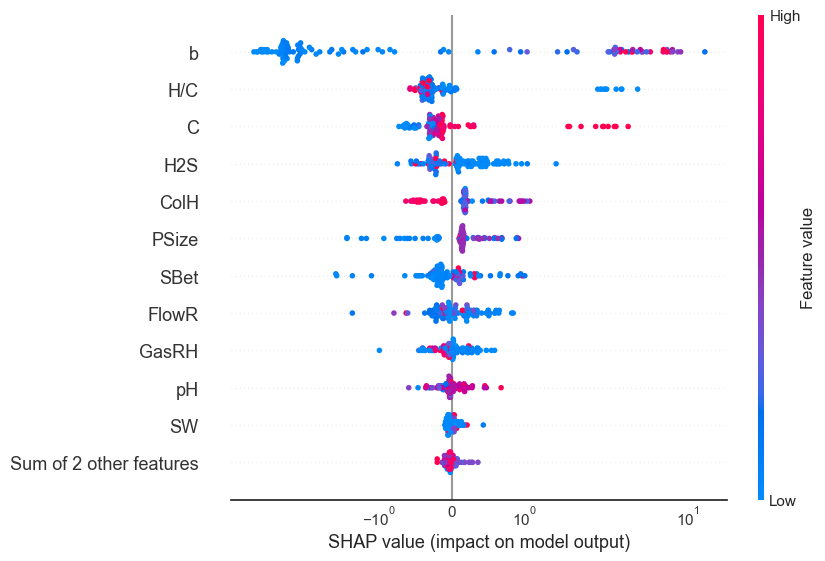

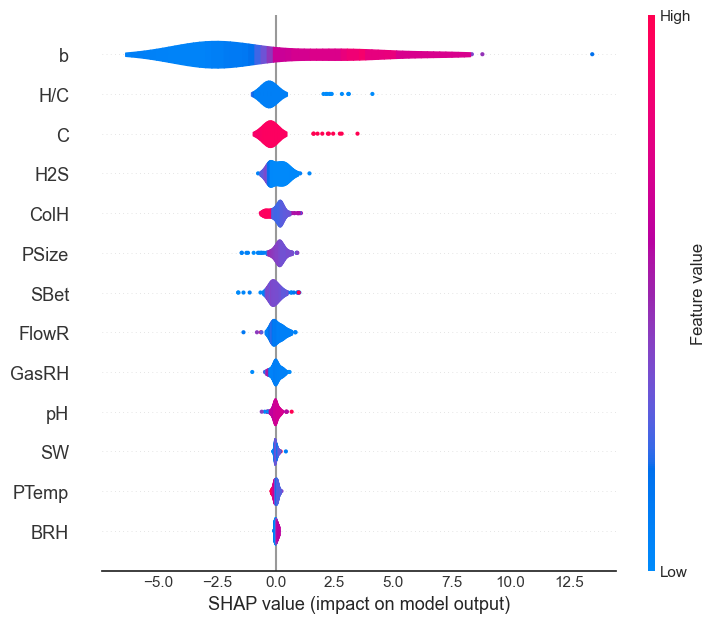

In [44]:
estimator = est
explainer = shap.Explainer(estimator, seed = 30, algorithm ='tree')
shap_values = explainer(X_train) 
ax=shap.plots.bar(shap_values, max_display=12, order=shap.Explanation.abs, show=True)
ax1=shap.plots.beeswarm(shap_values, max_display=12, log_scale=True)
ax2=shap.summary_plot(shap_values, X_train, plot_type="violin", color_bar_label='Feature value',layered_violin_max_num_bins=40)


In [45]:
RFR_a_dr=joblib.load('RFR_a_dr.sav')
a_pred=RFR_a_dr.predict(X)

Results_df['a_pred']=0
for i in range(0, len(Results_df)):
    Results_df['a_pred'].iloc[i]=float(a_pred[i].round(3))
Results_df

,GasRH,H2S,FlowR,C,H/C,pH,SBet,PTemp,BRH,PSize,...,T,T_xgbr,T_gbr,T_rfr,K_pred,K_pred_teor,b_xgbr,b_gbr,b_rfr,a_pred
0,0.0,50.0,40.0,22.20,0.355856,5.25,2.10,100.0,0.0,0.825,...,25.183979,26.285999,29.279,55.128,8.821000,3.906200,32.176998,35.073,58.237,4.592
1,0.0,50.0,40.0,22.20,0.355856,5.40,6.40,200.0,0.0,0.825,...,123.303715,116.674004,120.113,102.863,26.811001,20.706128,125.272003,125.883,112.033,7.381
2,0.0,50.0,40.0,22.20,0.355856,6.00,11.30,300.0,0.0,0.825,...,140.847082,135.927994,140.203,123.105,21.170000,23.809988,144.746002,147.944,132.437,8.800
3,0.0,50.0,40.0,22.20,0.355856,9.50,20.35,400.0,0.0,0.825,...,494.556257,479.218994,484.514,434.773,42.563000,89.022629,501.013000,503.046,461.235,16.549
4,0.0,50.0,40.0,22.20,0.355856,9.00,22.60,500.0,0.0,0.825,...,249.228841,288.127014,287.227,310.366,30.948999,43.351302,309.875000,311.657,321.664,10.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,40.0,10000.0,2700.0,38.94,0.170262,8.08,45.00,700.0,0.0,1.000,...,0.131768,5.862000,7.001,22.685,1.598000,0.015717,9.454000,16.030,29.904,2.405
126,40.0,10000.0,2700.0,27.71,0.174666,12.27,12.00,700.0,0.0,1.000,...,45.104694,45.359001,48.630,78.575,17.523001,7.202890,54.292000,56.818,80.714,3.918
127,40.0,10000.0,2700.0,33.73,0.143492,9.73,55.00,700.0,90.0,1.000,...,12.811105,14.558000,16.805,38.324,13.001000,1.921055,19.400999,24.227,46.313,2.897
128,40.0,10000.0,2700.0,38.94,0.170262,8.08,45.00,700.0,90.0,1.000,...,45.242404,42.431999,44.945,42.460,18.171000,7.225982,48.912998,51.569,48.800,3.923


In [46]:
Results_df.to_pickle('Results_df2.pkl')

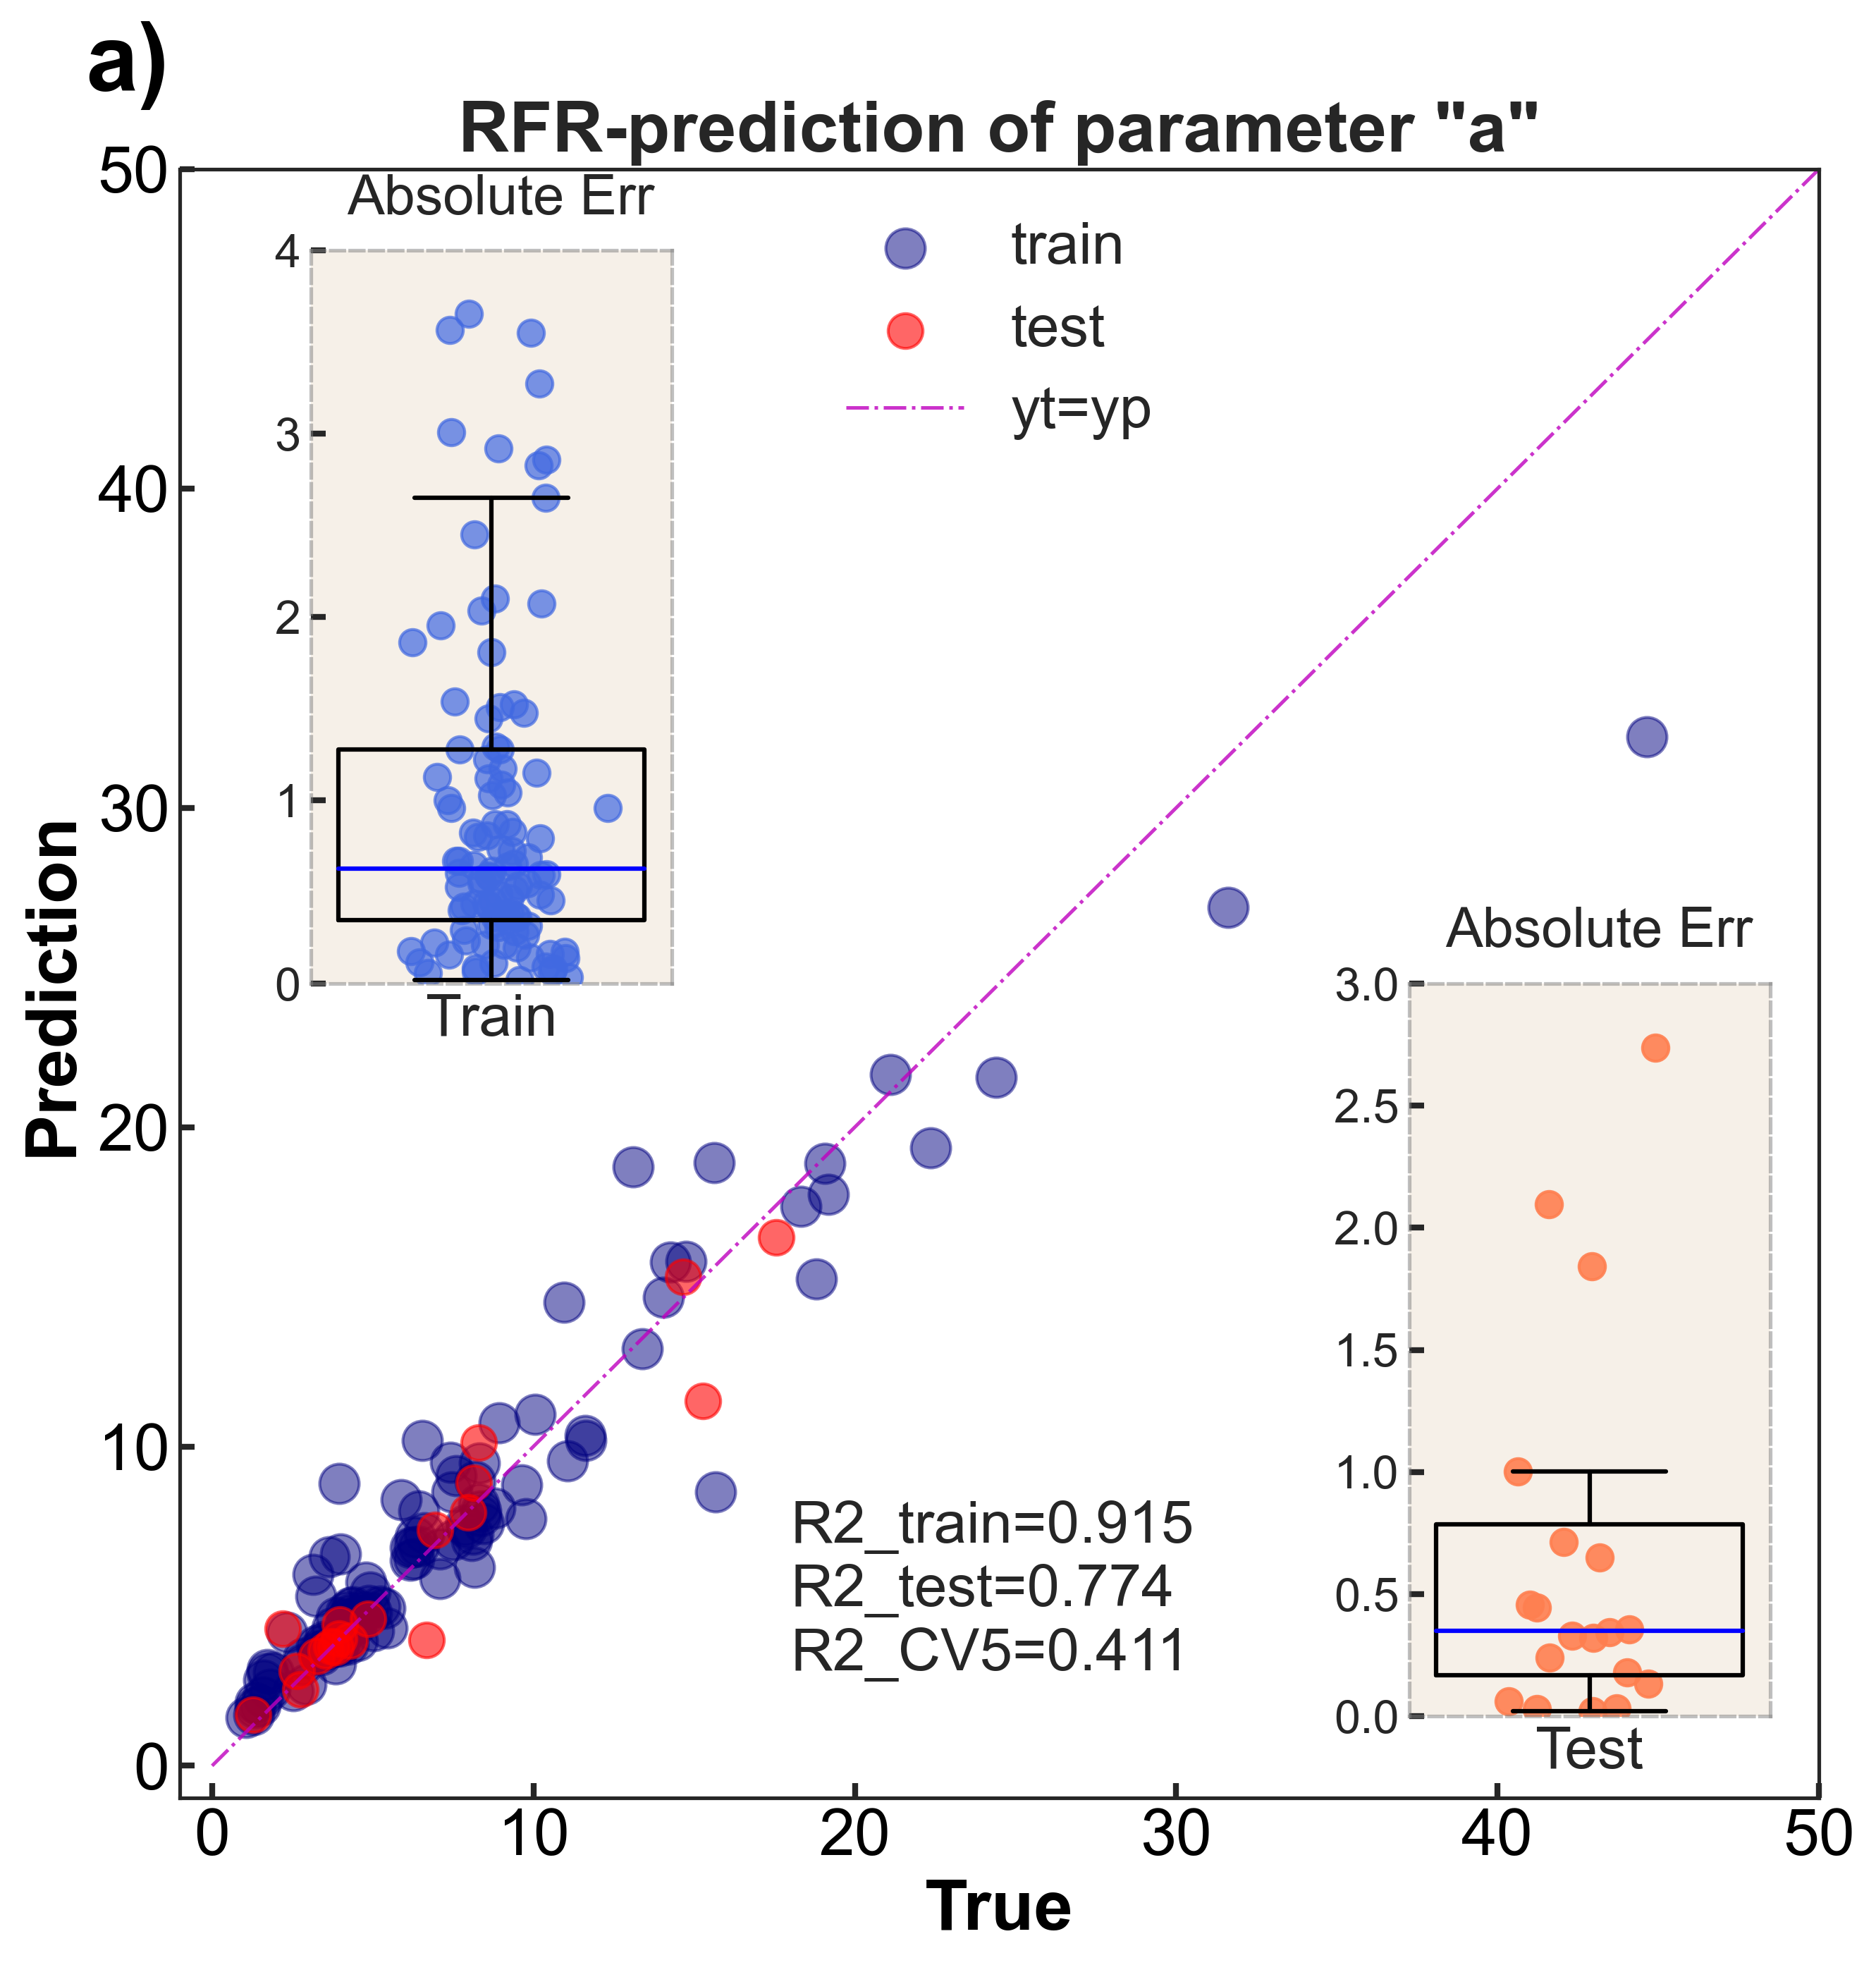

In [47]:
import matplotlib.gridspec as gridspec
 
fontdict1={'fontsize': 12, 'fontweight': 'bold', 'fontfamily': 'arial'}
fontdict2={'fontsize': 24, 'fontweight': 'bold', 'color': 'k', 'fontfamily': 'arial'}
rs=[60]

RFR= joblib.load('RFR_a_dr.sav')


yp_train_RFR= RFR.predict(X_train)
yp_test_RFR= RFR.predict(X_train)

fig = plt.figure(figsize=(10,10), dpi=300)
gs  = gridspec.GridSpec(1, 1, wspace=0.15, hspace=0.1, width_ratios=[1], height_ratios=[1])
modelsName=['RFR-prediction of parameter "a"']

YP_train=[yp_train_RFR]

j=0
for i in range(0,1):
    ax = fig.add_subplot(gs[0,j])
    #------------------------------------------------ Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = rs[i])

    yp_train_RFR= RFR.predict(X_train)
    yp_test_RFR= RFR.predict(X_test)
    YP_train=[yp_train_RFR]
    YP_test=[yp_test_RFR]
    
    ax.scatter(y_train, YP_train[i], s=180, color='navy',label='train', alpha=0.5)
    ax.scatter(y_test, YP_test[i], s=140, color='r',label='test', alpha=0.6)
    ax.plot([0, 50], [0, 50], 'k-.', lw=1.2, label='yt=yp', alpha=.8, color='m')

    #-----------------------------------------------------------------------------------
    ax2=ax.inset_axes([0.08, .50, 0.22, 0.45])
    ax2.set_xticks([])
    ax2.tick_params(axis='y', labelsize=16)
    ax2.spines[['top', 'bottom','right', 'left' ]].set_color('gray')
    ax2.spines[['top', 'bottom','right', 'left' ]].set_linestyle('--')
    ax2.spines[['top', 'bottom','right', 'left' ]].set_alpha(0.5)
    ax2.set_facecolor('tan')
    ax2.patch.set_alpha(0.2)
    #--------------------------------------------
    # calculate the train eroors
    err_train=abs(y_train-YP_train[i]).round(3)
    #--------------------------------------------
    ax2.boxplot(err_train, widths=0.85,labels=['Train'], meanline =True,vert=True,
                showfliers = False,
                medianprops = {"color": "b", "linewidth": 1.5},
                boxprops = {"color": "k", "linewidth": 1.5},
                whiskerprops = {"color": "k", "linewidth": 1.5},
                capprops = {"color": "k", "linewidth": 1.5})
    xs, names = [], []
    vals=np.asanyarray(err_train)
    #names.append(col)
    xs.append(np.random.normal(1, 0.1, len(err_train)))
    ax2.scatter(xs,err_train, alpha= 0.7, marker='o', s=80, color='royalblue')
    ax2.text(0.6, 1.05*4, 'Absolute Err', fontsize = 19)
    ax2.set_ylim([0, 4])
    #-----------------------------------------------------------------------------------------
    #-----------------------------------------------------------------------------------------
    ax3=ax.inset_axes([0.75, .05, 0.22, 0.45])
    ax3.tick_params(axis='y', labelsize=16)
    ax3.set_xticks([])
    ax3.spines[['top', 'bottom','right', 'left' ]].set_color('gray')
    ax3.spines[['top', 'bottom','right', 'left' ]].set_linestyle('--')
    ax3.spines[['top', 'bottom','right', 'left' ]].set_alpha(0.5)
    ax3.set_facecolor('tan')
    ax3.patch.set_alpha(0.2)
    #--------------------------------------------
    # calculate the train eroors
    err_test=abs(y_test-YP_test[i]).round(3)
    #--------------------------------------------
    ax3.boxplot(err_test, widths=0.85,labels=['Test'], meanline =True,vert=True,
                showfliers = False,
                medianprops = {"color": "b", "linewidth": 1.5},
                boxprops = {"color": "k", "linewidth": 1.5},
                whiskerprops = {"color": "k", "linewidth": 1.5},
                capprops = {"color": "k", "linewidth": 1.5})
    xs, names = [], []
    vals=np.asanyarray(err_train)
    #names.append(col)
    xs.append(np.random.normal(1, 0.1, len(err_test)))
    ax3.scatter(xs,err_test, alpha= 0.9, marker='o', s=80, color='coral')
    ax3.text(0.6, 1.05*3, 'Absolute Err', fontsize = 19)
    ax3.set_ylim([0, 3])
    
    #------------------------------------------------------------------------------------------
    #------------------------------------------------------------------------------------------

    ax.set_xlim([-1, 50])
    ax.set_ylim([-1, 50])
    ax.set_xlabel('True', fontdict=fontdict2)
    if j==0:
        ax.set_ylabel('Prediction', fontdict=fontdict2)
    ax.set_title(modelsName[j]  , loc= 'center', fontdict = fontdict1, fontsize=24)
    ax.tick_params(labelcolor='k', labelsize='medium', width=3)
    ax.legend(loc= 'upper center', fontsize=20)
    ax.tick_params(axis='x', which='both', direction='in', length=5, width=2)
    ax.tick_params(axis='y', which='both', direction='in', length=5, width=2)
    ax2.tick_params(axis='y', which='both', direction='in', length=5, width=2)
    ax3.tick_params(axis='y', which='both', direction='in', length=5, width=2)
    #------------------------------------------------------------------------------------------

    ax.text(18, 7, 'R2_train=0.915', fontsize = 20)
    ax.text(18, 5,  'R2_test=0.774', fontsize = 20)
    ax.text(18, 3,  'R2_CV5=0.411', fontsize = 20)
    j=j+1
fig.suptitle('a)', fontsize=32, fontweight='bold', color='k', x=.1, y=0.95)
plt.savefig('dr_a_errors', dpi=300)
plt.show()